In [69]:
import pandas as pd
# this is a list of the column names in our dataset (as the file doesn't contain any headers)
names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

# some fields are categorical and will require special treatment
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
df = pd.read_csv("adult.txt", sep=", ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [70]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

full_spans = get_spans(df, df.index)
full_spans

{'age': 73,
 'workclass': 9,
 'fnlwgt': 1472420,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

In [71]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [72]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [73]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [74]:
# we get the number of partitions that were created
len(finished_partitions)

479

In [75]:
import matplotlib.pylab as pl
import matplotlib.patches as patches
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [76]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [77]:
# let's see how our rects look like
rects[:10]

[((17.0, 6.0), (21.0, 7.0)),
 ((21.0, 10.0), (22.0, 11.0)),
 ((25.0, 10.0), (27.0, 11.0)),
 ((37.0, 9.0), (39.0, 10.0)),
 ((37.0, 10.0), (38.0, 13.0)),
 ((39.0, 13.0), (41.0, 16.0)),
 ((41.0, 13.0), (43.0, 16.0)),
 ((17.0, 7.0), (18.0, 9.0)),
 ((18.0, 7.0), (21.0, 9.0)),
 ((19.0, 9.0), (20.0, 10.0))]

In [78]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

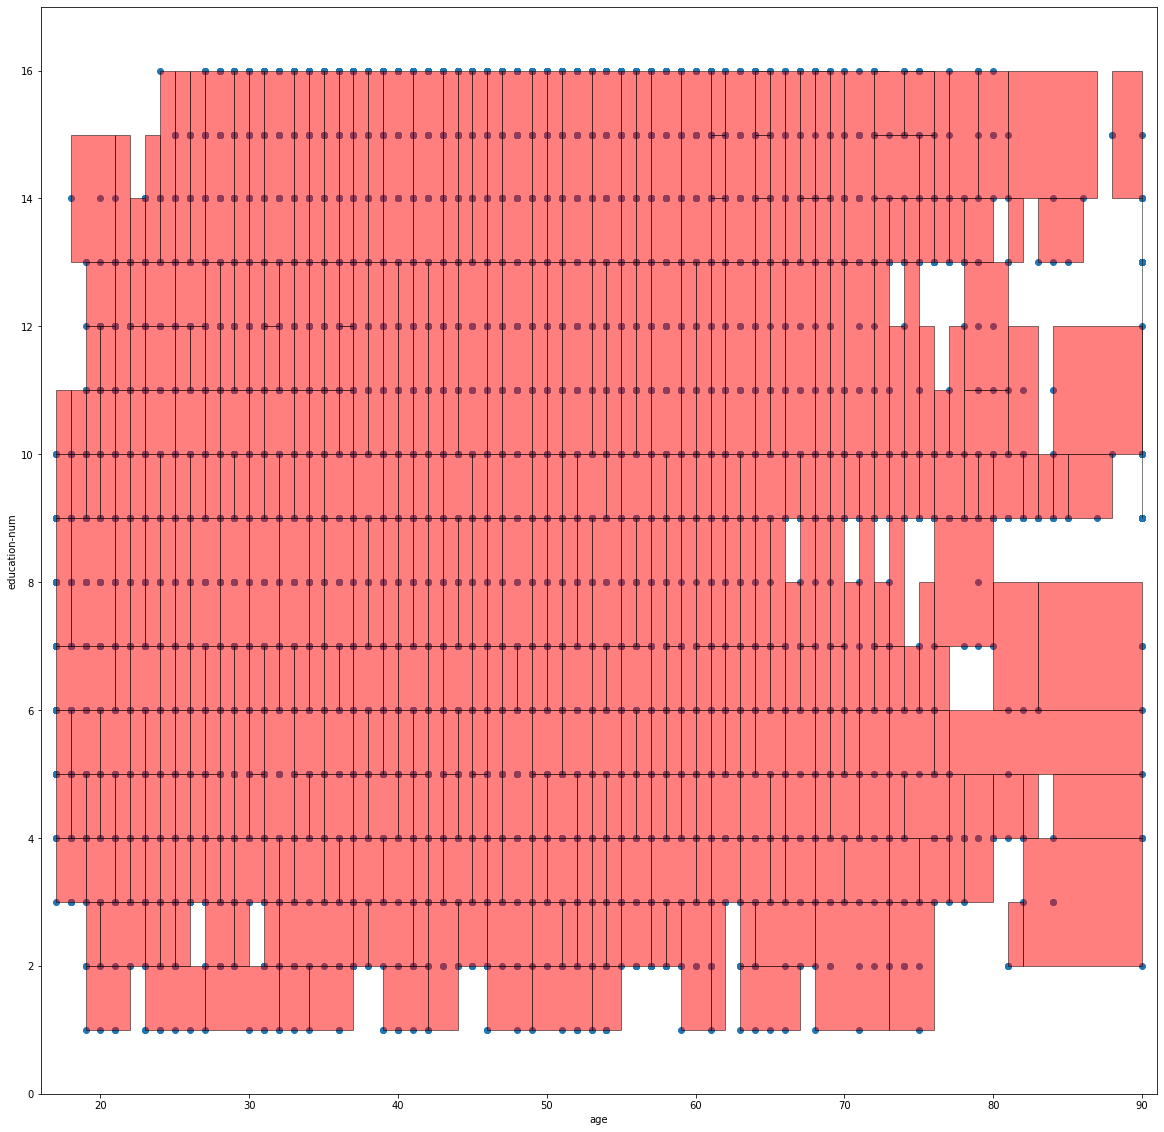

In [79]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [80]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [81]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [82]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns)



,age,count,education-num,income
333,17.000000,3,4.000000,<=50K
220,17.000000,25,5.000000,<=50K
13,17.000000,217,7.170507,<=50K
110,17.000000,8,9.000000,<=50K
40,17.000000,3,10.000000,<=50K
0,17.555556,207,6.000000,<=50K
317,17.800000,5,3.000000,<=50K
334,18.000000,5,4.000000,<=50K
111,18.000000,152,9.000000,<=50K
41,18.000000,116,10.000000,<=50K


In [83]:
# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [84]:
global_freqs

{'<=50K': 0.7591904425539756, '>50K': 0.2408095574460244}

In [85]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [86]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [87]:
len(finished_t_close_partitions)

101

In [88]:
dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)

# Let's see how t-closeness fares
dft.sort_values([column_x, column_y, sensitive_column])

Finished 1 partitions...
           age  count  education-num income
0    26.687217   6837       8.109708  <=50K
1    26.687217    446       8.109708   >50K
2    25.813018   3755      10.000000  <=50K
3    25.813018    347      10.000000   >50K
4    29.414861   2239      13.307121  <=50K
5    29.414861    991      13.307121   >50K
6    37.000000    566      10.257576  <=50K
7    37.000000    292      10.257576   >50K
8    41.491184   1039      10.561083  <=50K
9    41.491184    549      10.561083   >50K
10   24.489834    505      11.484288  <=50K
11   24.489834     36      11.484288   >50K
12   38.991903    834      12.020918  <=50K
13   38.991903    648      12.020918   >50K
14   43.000000    497      10.683117  <=50K
15   43.000000    273      10.683117   >50K
16   47.000000    420      10.456215  <=50K
17   47.000000    288      10.456215   >50K
18   50.497076    694      10.353383  <=50K
19   50.497076    503      10.353383   >50K
20   44.000000    443      10.722376  <=50K
21   44

In [89]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])


age
education-num


In [90]:
from sklearn.svm import SVC
from sklearn.metrics import *

#資料集載入的內容&資料集&目標集
X = df[['age','education-num']]
df['income']=df['income'].map({'>50K':1,'<=50K':0}).astype(int)
Y=df['income']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        1
9        1
10       1
11       1
12       0
13       0
14       1
15       0
16       0
17       0
18       0
19       1
20       1
21       0
22       0
23       0
24       0
25       1
26       0
27       1
28       0
29       0
        ..
32531    0
32532    1
32533    1
32534    0
32535    0
32536    1
32537    0
32538    1
32539    1
32540    0
32541    0
32542    0
32543    0
32544    0
32545    1
32546    0
32547    0
32548    0
32549    0
32550    0
32551    0
32552    0
32553    0
32554    1
32555    0
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int32


In [97]:
#將資料分為測試&訓練兩類，並將測試集設為25%
x_train, x_test,y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

#利用SVM帶入資料做訓練
clf= SVC(gamma='auto')
clf.fit(x_train, y_train)

#測試的準確度
Accuracy=clf.score(x_test, y_test)
print("測試Accuracy",Accuracy)

#將測試資料帶入做預測
y_predict = clf.predict(x_test)
#target_names=['Setosa','Versicolour','Virginica']
print ("混淆矩陣",'\n',confusion_matrix(y_test,y_predict))
print ("預測Accuracy",accuracy_score(y_test,y_predict))
print(classification_report(y_test,y_predict))

from sklearn import metrics
precision = metrics.precision_score(y_test,y_predict,pos_label=None,average=None)
if precision[0]>precision[1]:
    maximum=precision[0]
else:
    maximum=precision[1]
#missclassificationError=1-maximum
print('Missclassification Error: ',1-maximum)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#畫出roc計算AUC
fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=None)
print("AUC:",auc(fpr, tpr))

測試Accuracy 0.7892150841419973
混淆矩陣 
 [[5729  430]
 [1286  696]]
預測Accuracy 0.7892150841419973
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      6159
           1       0.62      0.35      0.45      1982

    accuracy                           0.79      8141
   macro avg       0.72      0.64      0.66      8141
weighted avg       0.77      0.79      0.77      8141

Missclassification Error:  0.18332145402708477
AUC: 0.640671957669357
